## Steps to preprocess EEG data include the following:

- Downsample the data
- Bandpass filter 
- Common Average Re-reference the data
- Segmentation
- ICA

|Sub ID | AdaBoost | Decision Tree | MLP | SVM | LDA | LSTM |
|----------|-------------|---------------|-------------|---------------|-------------|---------------|
|1 | 31.64%|25%|28.33%|28%| 20%|25%|
|2 | %| %| %|%| %|%|
|3 | %|%| %|%| %|%|
|4 | %|%| %|%| %|%|
|5 | %|%| %|%| %|%|
|6 | %|%| %|%| %|%|
|7 | %|%| %|%| %|%|
|8 | %|%| %|%| %|%|
|9 | %|%| %|%| %|%|
|10 | %|%| %|%| %|%|
|11 | 28.33%| 30%| 36.667%| 30%| 25%| 25%|
|12 | %|%| %|%| %|%|
|13 | %|%| %|%| %|%|
|14 | %|%| %|%| %|%|
|15 | %|%| %|%| %|%|
|16 | 26.68%|30%|28.33 %|0.2%|0.22 %|0.2%|
|17 | %|%| %|%| %|%|
|18 | %|%| %|%| %|%|
|19 | %|%| %|%| %|%|
|20 | %|%| %|%| %|%|
|21 | %|%| %|%| %|%|
|22 | %|%| %|%| %|%|
|23 | %|%| %|%| %|%|
|24 | %|%| %|%| %|%|
|25 | %|%| %|%| %|%|

## Arm Reaching - MI

In [1]:
# !pip install mne

import os
import glob
import numpy as np
import mne
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')
from scipy.io import loadmat
from scipy.signal import butter, lfilter

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne.decoding import CSP
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### BrainVision (.vhdr, .vmrk, .eeg)

The BrainVision file format consists of three separate files:

1. A text header file (.vhdr) containing meta data.

2. A text marker file (.vmrk) containing information about events in the data.

3. A binary data file (.eeg) containing the voltage values of the EEG.

In [2]:
folder_path=r'D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI'
folder_files=os.listdir(folder_path)
for i in folder_files:
    print(i)

session1_sub10_reaching_MI.eeg
session1_sub10_reaching_MI.vhdr
session1_sub10_reaching_MI.vmrk
session1_sub11_reaching_MI.eeg
session1_sub11_reaching_MI.vhdr
session1_sub11_reaching_MI.vmrk
session1_sub12_reaching_MI.eeg
session1_sub12_reaching_MI.vhdr
session1_sub12_reaching_MI.vmrk
session1_sub13_reaching_MI.eeg
session1_sub13_reaching_MI.vhdr
session1_sub13_reaching_MI.vmrk
session1_sub14_reaching_MI.eeg
session1_sub14_reaching_MI.vhdr
session1_sub14_reaching_MI.vmrk
session1_sub15_reaching_MI.eeg
session1_sub15_reaching_MI.vhdr
session1_sub15_reaching_MI.vmrk
session1_sub16_reaching_MI.eeg
session1_sub16_reaching_MI.vhdr
session1_sub16_reaching_MI.vmrk
session1_sub17_reaching_MI.eeg
session1_sub17_reaching_MI.vhdr
session1_sub17_reaching_MI.vmrk
session1_sub18_reaching_MI.eeg
session1_sub18_reaching_MI.vhdr
session1_sub18_reaching_MI.vmrk
session1_sub19_reaching_MI.eeg
session1_sub19_reaching_MI.vhdr
session1_sub19_reaching_MI.vmrk
session1_sub1_reaching_MI.eeg
session1_sub1_reachi

In [3]:
# eeg,vhdr,vmrk = [],[],[]

# for i in folder_files:
#     file=folder_path+'\\'+i
#     if '.eeg' in file:
#         eeg.append(file)
#     elif '.vhdr' in file:
#         vhdr.append(file)
#     else:
#         vmrk.append(file)

# for i in range(0,len(eeg)):
#     print(eeg[i]+'\n'+vhdr[i]+'\n'+vmrk[i]+'\n')

sub = 6
session = 1
eeg = folder_path+'\\'+f'session{session}_sub{sub}_reaching_MI.eeg'
vhdr = folder_path+'\\'+f'session{session}_sub{sub}_reaching_MI.vhdr'
vmrk = folder_path+'\\'+f'session{session}_sub{sub}_reaching_MI.vmrk'

### Read Raw Signals

In [4]:
raw = mne.io.read_raw_brainvision(vhdr, misc='auto', scale=1.0, preload=True, verbose=None)
raw # OR raw.info

Extracting parameters from D:\EEG_RawData\EEG_RawData\Arm-Reaching\MI\session1_sub6_reaching_MI.vhdr...
Setting channel info structure...
Reading 0 ... 10091699  =      0.000 ...  4036.680 secs...


<RawBrainVision | session1_sub6_reaching_MI.eeg, 71 x 10091700 (4036.7 s), ~5.34 GB, data loaded>

In [5]:
raw.set_channel_types(mapping={'hEOG_L': 'eog', 'hEOG_R': 'eog', 'vEOG_U': 'eog', 'vEOG_D': 'eog'})
raw.set_channel_types(mapping={'EMG_1': 'emg', 'EMG_2': 'emg', 'EMG_3': 'emg', 'EMG_4': 'emg', 'EMG_5': 'emg', 'EMG_6': 'emg', 'EMG_ref': 'emg'})
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, AFz, F7, F5, F3, F1, Fz, FT7, FC5, FC3, FC1, T7, ...
 chs: 60 EEG, 4 EOG, 7 EMG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1250.0 Hz
 meas_date: 2019-08-22 11:48:38 UTC
 nchan: 71
 projs: []
 sfreq: 2500.0 Hz
>

In [6]:
print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print(raw.info['sfreq'], 'Hz')            # sampling frequency
print(raw.info['description'], '\n')      # miscellaneous acquisition info

bad channels: []
2500.0 Hz
None 



Using matplotlib as 2D backend.


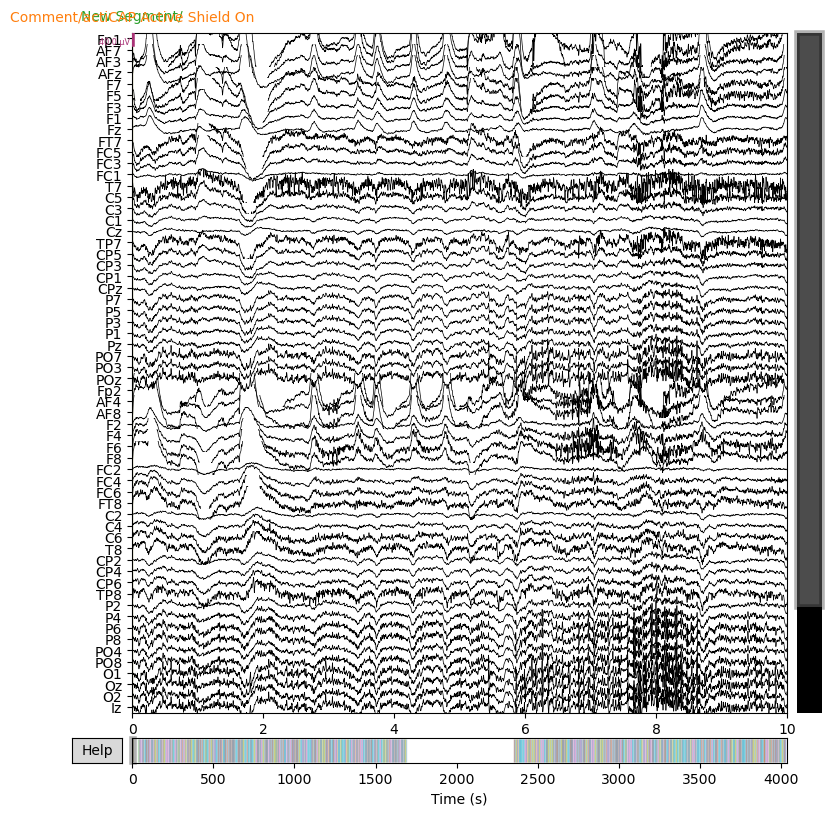

In [7]:
raw.plot(n_channels=60);

### For One Session, Each Subject Do :
 - 50 Trials For Each Class : 50 x 6 ( Classes ) = Total 300 Trials

 - Each Trial has Time Duration 7s ( 3s Visual Cue + 4s Movement Implementation )

 - and There Are 300 Rest Periods Between Those Trials ( Each Rest Period has Time Duration 4s )

 - Finally,
      Total Session Time = 50 x 6 x 7 + 300 x 4 = almost 3300 seconds

In [8]:
print('First Time : ',raw.first_time)
print('Last Time  : ',raw._last_time)

First Time :  0.0
Last Time  :  4036.6796


- Therefore, The Total Count of Samples For All Trials : 300 ( Trials ) x 7s x 2500 (Fs) + 300 (Rests) x 4s x 2500 (Fs) is almost 8,250,000

In [9]:
print('Total Samples : ',len(raw))
print('Start : ',raw._first_samps)
print('End : ',raw._last_samps)

Total Samples :  10091700
Start :  [0]
End :  [10091699]


### time_as_index()
- Convert time to indices ( time ( s ) : index ( 0-based ) )

- Input : List of numbers or a number representing points in time.

- Return : Indices relative to first_samp corresponding to the times supplied.

In [10]:
print(raw.time_as_index([1, 2, 3, 4, 5]), '\n')
print(np.diff(raw.time_as_index([1, 2, 3])))

[ 2500  5000  7500 10000 12500] 

[2500 2500]


### Electrodes Handling :
### pick_types() : Picking Some Type of Signals and Ignore Others.
### pick_channels() : pick channels by name.
### drop_channels() : method to remove channels by name.

In [11]:
raw.pick_types(emg=False, eeg=True, eog=False)
print(len(raw.ch_names))

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
60


### Downsampling

In [12]:
print(raw.info['sfreq'], 'Hz')          

2500.0 Hz


In [13]:
raw.resample(sfreq=1250)

<RawBrainVision | session1_sub6_reaching_MI.eeg, 60 x 5045850 (4036.7 s), ~2.26 GB, data loaded>

In [14]:
print(raw.info['sfreq'], 'Hz')    

1250.0 Hz


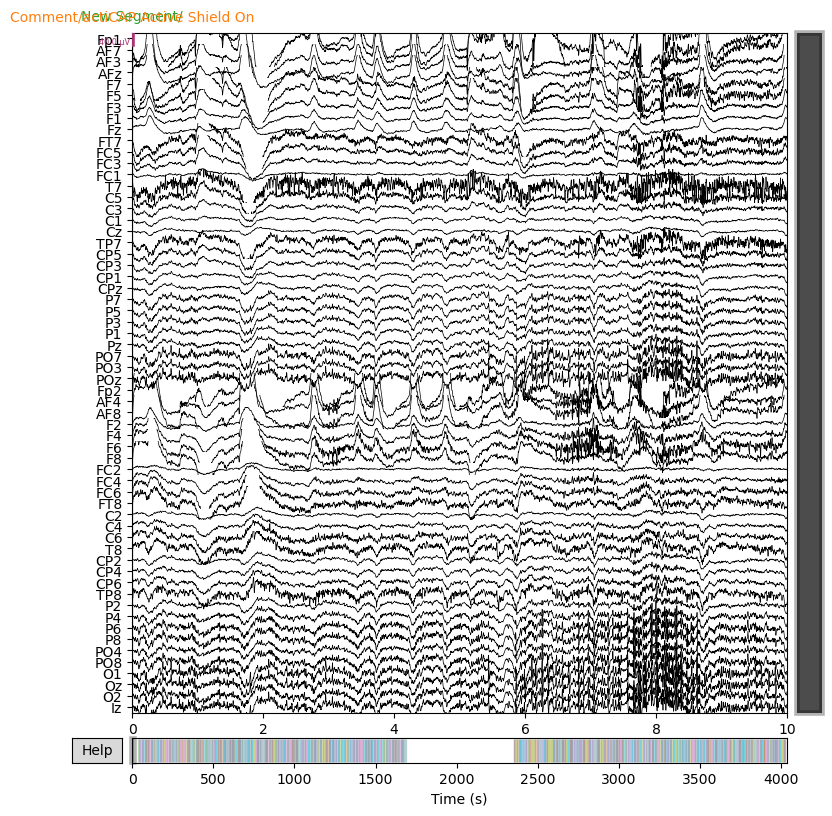

In [15]:
raw.plot(n_channels=60);

### Bandpass Filtering the Data
- Filtering to remove slow drift.
- Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit.

In [16]:
raw.filter(l_freq=8, h_freq=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 2063 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    9.7s finished


<RawBrainVision | session1_sub6_reaching_MI.eeg, 60 x 5045850 (4036.7 s), ~2.26 GB, data loaded>

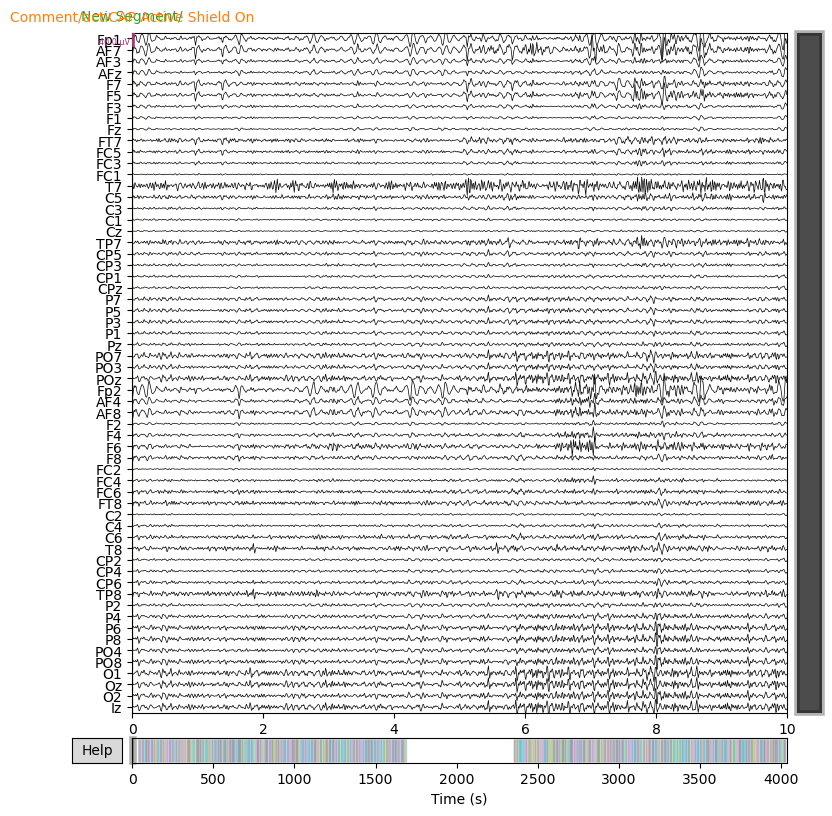

In [17]:
raw.plot(n_channels=60);

### Refrencing EEG

In [18]:
# Average reference. This is normally added by default, but can also be added
# explicitly.
raw.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | session1_sub6_reaching_MI.eeg, 60 x 5045850 (4036.7 s), ~2.26 GB, data loaded>

### Read Events & Epoching

In [19]:
events = mne.events_from_annotations(raw)

Used Annotations descriptions: ['Comment/ControlBox is not connected via USB', 'Comment/actiCAP Active Shield On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']


In [20]:
list(events[1:])

[{'Comment/ControlBox is not connected via USB': 10001,
  'Comment/actiCAP Active Shield On': 10002,
  'New Segment/': 99999,
  'Stimulus/S  1': 1,
  'Stimulus/S  2': 2,
  'Stimulus/S  3': 3,
  'Stimulus/S  4': 4,
  'Stimulus/S  5': 5,
  'Stimulus/S  6': 6,
  'Stimulus/S  8': 8,
  'Stimulus/S 11': 11,
  'Stimulus/S 13': 13,
  'Stimulus/S 14': 14,
  'Stimulus/S 21': 21,
  'Stimulus/S 31': 31,
  'Stimulus/S 41': 41,
  'Stimulus/S 51': 51,
  'Stimulus/S 61': 61}]

In [21]:
list(events[0])

[array([    0,     0, 99999]),
 array([    0,     0, 10002]),
 array([44858,     0,    13]),
 array([49914,     0,     4]),
 array([53672,     0,    41]),
 array([58708,     0,     8]),
 array([63835,     0,     3]),
 array([67590,     0,    31]),
 array([72623,     0,     8]),
 array([77684,     0,     1]),
 array([81439,     0,    11]),
 array([86477,     0,     8]),
 array([91540,     0,     6]),
 array([95294,     0,    61]),
 array([100331,      0,      8]),
 array([105392,      0,      2]),
 array([109148,      0,     21]),
 array([114186,      0,      8]),
 array([119252,      0,      2]),
 array([123007,      0,     21]),
 array([128038,      0,      8]),
 array([133105,      0,      3]),
 array([136860,      0,     31]),
 array([141892,      0,      8]),
 array([146956,      0,      4]),
 array([150711,      0,     41]),
 array([155746,      0,      8]),
 array([160812,      0,      1]),
 array([164566,      0,     11]),
 array([169600,      0,      8]),
 array([174662,      0

### 1st Method

In [22]:
# mne.viz.plot_events(events[0][:100]);

In [23]:
# event_ids = {'Stimulus/S 11': 11,'Stimulus/S 21': 21,'Stimulus/S 31': 31,'Stimulus/S 41': 41,'Stimulus/S 51': 51,'Stimulus/S 61': 61}
# epochs = mne.Epochs(raw, events=events[0], event_id=event_ids, tmin=4, tmax=7, preload=True,baseline=(0, 0))

In [24]:
# epochs

In [25]:
# epochs.get_data().shape

### 2nd Method

In [26]:
selected_events = mne.pick_events(events[0], exclude=[99999,10001,10002,10003,1,2,3,4,5,6,13,14])
selected_events

array([[  53672,       0,      41],
       [  58708,       0,       8],
       [  67590,       0,      31],
       ...,
       [5012871,       0,       8],
       [5021687,       0,      21],
       [5026725,       0,       8]])

In [27]:
print(selected_events.shape)

(600, 3)


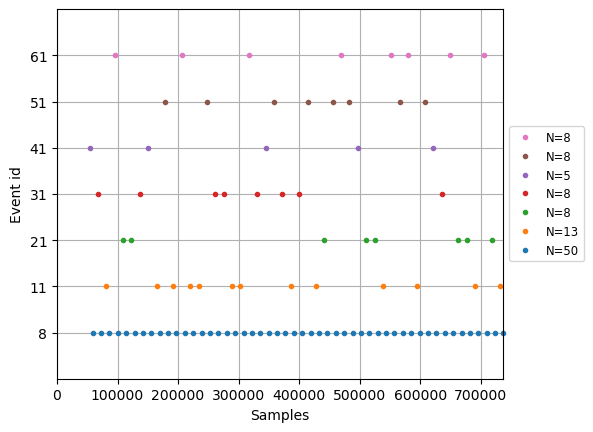

In [28]:
mne.viz.plot_events(selected_events[:100]);

In [29]:
event_ids = {'Stimulus/S 11': 11,'Stimulus/S 21': 21,'Stimulus/S 31': 31,'Stimulus/S 41': 41,'Stimulus/S 51': 51,'Stimulus/S 61': 61}
epochs = mne.Epochs(raw, events=selected_events, event_id=event_ids, tmin=0, tmax=7, preload=True,baseline=(0, 0))

Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 8751 original time points ...
0 bad epochs dropped


In [30]:
epochs

Number of events,300
Events,Stimulus/S 11: 50Stimulus/S 21: 50Stimulus/S 31: 50Stimulus/S 41: 50Stimulus/S 51: 50Stimulus/S 61: 50
Time range,0.000 – 7.000 s
Baseline,0.000 – 0.000 s


In [31]:
print(epochs.get_data().shape)

(300, 60, 8751)


In [32]:
epochs.crop(tmin=3,tmax=7,include_tmax=True)
epochs.get_data().shape

(300, 60, 5001)

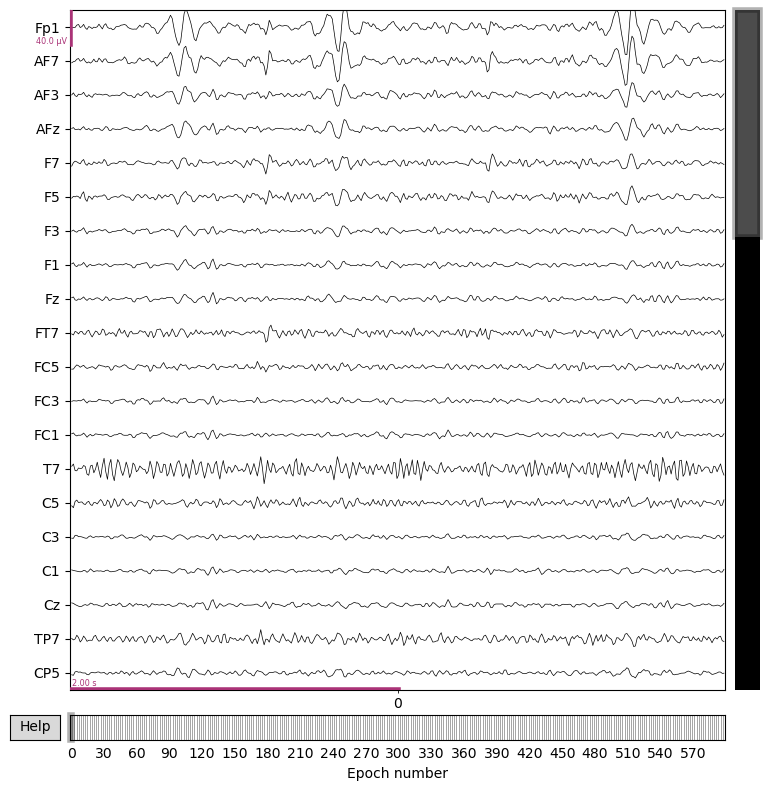

In [33]:
epochs.plot(n_epochs=1);

### Repairing artifacts with ICA
Note : ICA fitting is not deterministic (e.g., the components may get a sign flip on different runs, or may not always be returned in the same order), so we’ll also specify a random seed so that we get identical results each time this tutorial is built by our web servers

In [34]:
# from mne.channels import make_standard_montage

# # Manually define the sensor positions
# ch_names = list(raw.ch_names)

# # Create a standard montage with the specified channel names
# montage = make_standard_montage('standard_1005')
# montage.ch_names = ch_names

# # Set the montage to your raw or epochs object
# raw.set_eeg_montage(montage)
# epochs.set_montage(montage)

In [35]:
# ica = mne.preprocessing.ICA(n_components=60, max_iter='auto',random_state=42,method='fastica')
# ica.fit(epochs.copy(), picks='eeg')

In [36]:
# ica.plot_components()

In [37]:
# # use automatic detection
# bad_indx,scores = ica.find_bads_eog(epochs,ch_name=["hEOG_L","hEOG_R","vEOG_U","vEOG_D"])
# print(bad_indx)

In [38]:
# bad_indx

In [39]:
# epochs.plot(n_epochs=1);

In [40]:
# ica_copy = ica.copy()
# ica_copy.exclude = bad_indx
# ica_copy.apply(epochs.copy(),exclude=ica_copy.exclude).plot(n_epochs=1);

In [41]:
# ica.apply(epochs,exclude=ica.exclude) 

### Prepare Data

In [42]:
epochs.pick_types(eeg=True, eog=False)
data = epochs.get_data()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [43]:
labels = np.empty(shape=(data.shape[0]))
decode = {11: 0, 21: 1, 31: 2, 41:3, 51: 4, 61: 5, 8 :6}
k=0
for i in epochs.events:
    labels[k]=decode[i[2]]
    k+=1

In [44]:
data.shape , labels.shape

((300, 60, 5001), (300,))

## DWT

In [45]:
def preprocess_using_wavelet(filtered_signal):
    import pywt
    from pywt import wavedec ,waverec

    wavelet = 'db4'
    level = 5

    # db8,level 5
    # Daubechies sym7
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)

    for i in range(1, level):
        coeffs[i] = np.zeros_like(coeffs[i])

    res = pywt.waverec(coeffs, wavelet)
    return res


dwt_features=preprocess_using_wavelet(data)

In [46]:
plt.plot(dwt_features[0][0])

In [47]:
dwt_features.shape , labels.shape

((300, 60, 5002), (300,))

## Train-Test Split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2,stratify=labels,shuffle=True)

In [49]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((240, 60, 5001), (60, 60, 5001), (240,), (60,))

## CSP

In [50]:
csp=mne.decoding.CSP(60)

X_train_csp = csp.fit_transform(X_train,y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None


    Using tolerance 0.00012 (2.2e-16 eps * 60 dim * 9.1e+09  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 60 dim * 9.5e+09  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 60 dim * 1e+10  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
D

In [51]:
X_train_csp.shape , X_test_csp.shape

((240, 60), (60, 60))

## LDA

In [52]:
# ‘svd’, ‘lsqr’, ‘eigen’
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_test_csp, y_test]

# model accuracy for svc model
train_accuracy = lda.score(*evaluate_train)
test_accuracy = lda.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  0.9916666666666667
test accuracy:   0.16666666666666666


In [53]:
# training a linear SVM classifier
from sklearn import svm

# linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
model = svm.SVC(kernel='rbf', degree=7).fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_test_csp, y_test]

# model accuracy for svc model

train_accuracy = model.score(*evaluate_train)
test_accuracy = model.score(*evaluate_test)
print('train accuracy: ',str(train_accuracy))
print('test accuracy:  ',str(test_accuracy))

train accuracy:  0.9958333333333333
test accuracy:   0.13333333333333333


In [54]:
# training a linear SVM classifier

# kernel: ((...) -> Any) | Literal['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'] = "rbf",
svm_kernel_ovo = OneVsOneClassifier(SVC(kernel='rbf', degree=30)).fit(X_train_csp, y_train)
svm_kernel_ovr = OneVsRestClassifier(SVC(kernel='rbf', degree=30)).fit(X_train_csp, y_train)

evaluate_train=[X_train_csp, y_train]
evaluate_test=[X_test_csp, y_test]

# model accuracy for svc model
train_accuracy = svm_kernel_ovr.score(*evaluate_train)
test_accuracy = svm_kernel_ovr.score(*evaluate_test)
print('Linear Kernel OneVsRest SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

train_accuracy = svm_kernel_ovo.score(*evaluate_train)
test_accuracy = svm_kernel_ovo.score(*evaluate_test)
print('Linear Kernel OneVsOne SVM accuracy: ')
print('          train accuracy: ',str(train_accuracy))
print('          test accuracy:  ',str(test_accuracy))
print('_' * 40)

Linear Kernel OneVsRest SVM accuracy: 
          train accuracy:  1.0
          test accuracy:   0.2
________________________________________


Linear Kernel OneVsOne SVM accuracy: 
          train accuracy:  0.9958333333333333
          test accuracy:   0.13333333333333333
________________________________________


## AdaBoost

In [55]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=30),
                         algorithm="SAMME",
                         n_estimators=100,learning_rate=0.01)

bdt.fit(X_train_csp,y_train)
y_prediction = bdt.predict(X_test_csp)
accuracy=np.mean(y_prediction == y_test)*100
print ("Adaboost: " + str(accuracy))

Adaboost: 8.333333333333332


## Decision Tree

In [56]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf.fit(X_train_csp,y_train)

y_prediction = clf.predict(X_test_csp)
accuracy=np.mean(y_prediction == y_test)*100
print ("Decision Tree: " + str(accuracy))

Decision Tree: 8.333333333333332


## MLP

In [79]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(20), activation='relu')

mlp.fit(X_train_csp, y_train)

print(f"Train Accuracy: {mlp.score(X_train_csp, y_train)*100:.3f}%")
print(f"Test Accuracy: {mlp.score(X_test_csp, y_test)*100:.3f}%")

Train Accuracy: 99.583%
Test Accuracy: 13.333%


## CNN + CSP

In [58]:
def preprocess_input(eeg_signals):
    eeg_signals_2d = np.zeros((eeg_signals.shape[0], 60, 2))
    for i in range(eeg_signals.shape[0]):
        trial_2d = np.dstack([eeg_signals[0],eeg_signals[0]])
        eeg_signals_2d[i] = trial_2d
    return eeg_signals_2d
X_train_2d = preprocess_input(X_train_csp)
X_test_2d = preprocess_input(X_test_csp)

In [59]:
y_train_=tf.keras.utils.to_categorical(y_train,num_classes=6) 
y_test_=tf.keras.utils.to_categorical(y_test,num_classes=6) 

In [60]:
X_train_2d.shape , X_test_2d.shape , y_train_.shape , y_test_.shape

((240, 60, 2), (60, 60, 2), (240, 6), (60, 6))

In [61]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(60,2)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [62]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 64)            448       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 256)           98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 256)           0

In [64]:
Epochs=100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = model.fit(X_train_2d,y_train_,
                    epochs=Epochs,
                    validation_data=(X_test_2d,y_test_),
                     batch_size=32,
                     verbose=1)         #,callbacks=[early_stopping]

Epoch 1/100


8/8 [==============================] - 2s 76ms/step - loss: 1.7955 - accuracy: 0.1667 - val_loss: 1.7922 - val_accuracy: 0.1667
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 1.7945 - accuracy: 0.1708 - val_loss: 1.7926 - val_accuracy: 0.1667
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 1.7941 - accuracy: 0.1417 - val_loss: 1.7925 - val_accuracy: 0.1667
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 1.7989 - accuracy: 0.1125 - val_loss: 1.7923 - val_accuracy: 0.1667
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 1.7942 - accuracy: 0.1458 - val_loss: 1.7927 - val_accuracy: 0.1667
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 1.7940 - accuracy: 0.1458 - val_loss: 1.7932 - val_accuracy: 0.1667
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 1.7957 - accuracy: 0.1458 - val_loss: 1.7922 - val_accuracy: 0.1667
Epoch 8/100
8/8 [===============

In [65]:
model.evaluate(X_test_2d,y_test_)[1]

2/2 [==============================] - 0s 6ms/step - loss: 1.7921 - accuracy: 0.1667


0.1666666716337204

## LSTM + CSP

In [66]:
import tensorflow as tf
def build_model(num_classes):

    inputs = tf.keras.Input(shape=(None, 60))
    x = tf.keras.layers.Reshape((-1, 60))(inputs)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(64)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [67]:
user_model = build_model(num_classes=6)
Epochs=20
user_history = user_model.fit(
    X_train_csp,
    y_train,
    validation_split=0.2,
    epochs=Epochs,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=3,
#             restore_best_weights=True
#         )
#     ]
)

Epoch 1/20
6/6 [==============================] - 8s 285ms/step - loss: 1.7886 - accuracy: 0.3385 - val_loss: 1.7841 - val_accuracy: 0.5417
Epoch 2/20
6/6 [==============================] - 0s 20ms/step - loss: 1.7743 - accuracy: 0.6562 - val_loss: 1.7717 - val_accuracy: 0.5625
Epoch 3/20
6/6 [==============================] - 0s 20ms/step - loss: 1.7508 - accuracy: 0.7240 - val_loss: 1.7482 - val_accuracy: 0.5833
Epoch 4/20
6/6 [==============================] - 0s 19ms/step - loss: 1.7033 - accuracy: 0.7865 - val_loss: 1.7010 - val_accuracy: 0.6250
Epoch 5/20
6/6 [==============================] - 0s 20ms/step - loss: 1.6067 - accuracy: 0.8177 - val_loss: 1.6067 - val_accuracy: 0.6875
Epoch 6/20
6/6 [==============================] - 0s 19ms/step - loss: 1.4388 - accuracy: 0.8333 - val_loss: 1.4478 - val_accuracy: 0.7083
Epoch 7/20
6/6 [==============================] - 0s 18ms/step - loss: 1.1848 - accuracy: 0.8438 - val_loss: 1.2012 - val_accuracy: 0.7708
Epoch 8/20
6/6 [==========

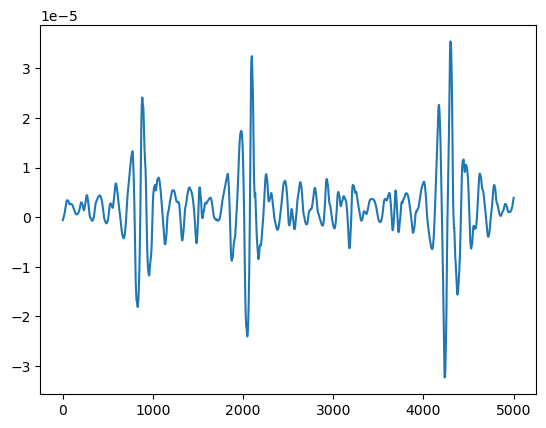

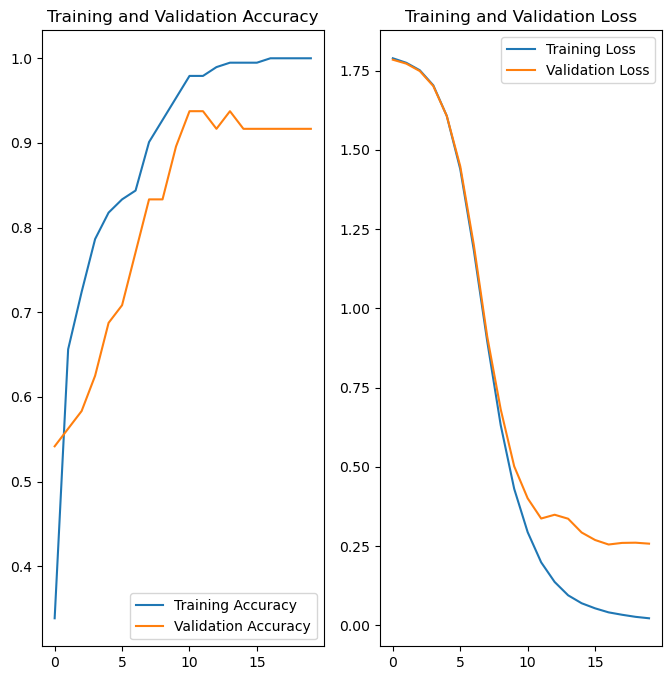

In [68]:
import matplotlib.pyplot as plt
history=user_history

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
user_model.evaluate(X_test_csp, y_test,verbose=0)[1]

0.21666666865348816